In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.datasets import fetch_california_housing


# California housing prices 

In [ ]:
ch = fetch_california_housing(as_frame=True)

In [ ]:
X = ch.frame

In [ ]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
y = X.pop('MedHouseVal')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 49 kB/s 


In [ ]:
X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(X_train, y_train, test_size=0.3, shuffle=True)

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 210 kB 50.1 MB/s 
     |████████████████████████████████| 78 kB 7.3 MB/s 
     |████████████████████████████████| 112 kB 62.8 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 146 kB 51.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=eee239b24a96f828759a83178d040ade64e1a17f1016242961668fed24fa608b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

In [ ]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Grid Serach

In [ ]:
def objective_gs(trial):

    params = {
        "n_estimators": trial.suggest_categorical("n", [5, 10, 50, 100, 200]),
        "max_depth": trial.suggest_int("max_depth", 3, 13),
        "learning_rate": trial.suggest_float("lr", 1e-3, 1),
        "l2_leaf_reg": trial.suggest_float("l2_reg", 1, 9),
        "eval_metric": "RMSE"
    }

    clf_obj = CatBoostRegressor(**params)
    clf_obj.fit(X_train_t, y_train_t, eval_set=(X_val_t, y_val_t), use_best_model=True, verbose=0)
    pred = clf_obj.predict(X_val_t)
    RMSE = mean_squared_error(y_val_t, pred, squared=False)
    return RMSE

In [ ]:
%%time
search_space = {"n": [5, 10, 50, 100, 200], 'max_depth': [3, 5, 7, 10, 12], 'lr': np.logspace(-3, 0, 10), "l2_reg": [1, 3, 5, 7, 9]}
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective_gs)

CPU times: user 1h 9min 14s, sys: 1min 2s, total: 1h 10min 16s
Wall time: 39min 12s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1440x1296 with 0 Axes>

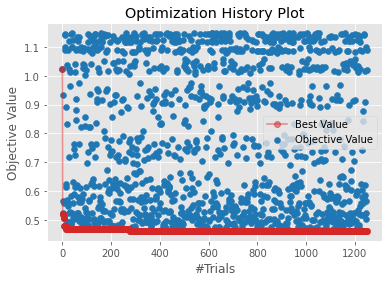

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('GB_GS_HIST.pdf')

In [ ]:
print('GB, grid search, best trial:')
print(study.best_trial.params)
print('GB, grid search, best RMSE:')
print(study.best_value)
print('GB, grid search, best trial number:')
print(study.best_trial.number)

GB, grid search, best trial:
{'n': 200, 'max_depth': 7, 'lr': 0.21544346900318823, 'l2_reg': 7}
GB, grid search, best RMSE:
0.4611960251233466
GB, grid search, best trial number:
276


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1440x1296 with 0 Axes>

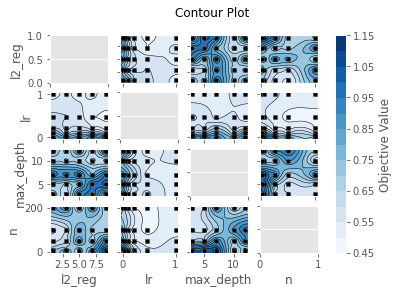

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=["n", "max_depth", "lr", "l2_reg"])
plt.savefig('GB_GS_CP.pdf')

In [ ]:
def evaluate_RMSE(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    RMSE = mean_squared_error(y_test, pred, squared=False)
    return RMSE

In [ ]:
model = CatBoostRegressor(n_estimators=study.best_trial.params['n'], 
                          max_depth=study.best_trial.params['max_depth'], learning_rate=study.best_trial.params['lr'], 
                          l2_leaf_reg=study.best_trial.params['l2_reg'], eval_metric='RMSE')
print('GB, grid search, RMSE on test:')
print(evaluate_RMSE(model, X_train, y_train, X_test, y_test))

GB, grid search, RMSE on test:
0:	learn: 1.0233489	total: 6.27ms	remaining: 1.25s
1:	learn: 0.9205744	total: 12.5ms	remaining: 1.24s
2:	learn: 0.8404571	total: 18.8ms	remaining: 1.23s
3:	learn: 0.7719052	total: 25.2ms	remaining: 1.24s
4:	learn: 0.7266016	total: 31.5ms	remaining: 1.23s
5:	learn: 0.6915961	total: 37.7ms	remaining: 1.22s
6:	learn: 0.6659625	total: 44.1ms	remaining: 1.22s
7:	learn: 0.6484357	total: 50ms	remaining: 1.2s
8:	learn: 0.6249551	total: 56ms	remaining: 1.19s
9:	learn: 0.6092079	total: 62.1ms	remaining: 1.18s
10:	learn: 0.6000910	total: 68.1ms	remaining: 1.17s
11:	learn: 0.5906916	total: 74.3ms	remaining: 1.16s
12:	learn: 0.5802387	total: 80.3ms	remaining: 1.15s
13:	learn: 0.5731626	total: 86.4ms	remaining: 1.15s
14:	learn: 0.5647473	total: 92.8ms	remaining: 1.14s
15:	learn: 0.5602204	total: 99ms	remaining: 1.14s
16:	learn: 0.5542937	total: 105ms	remaining: 1.13s
17:	learn: 0.5483105	total: 111ms	remaining: 1.12s
18:	learn: 0.5442803	total: 117ms	remaining: 1.12s
1

# Random search

In [ ]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_categorical("n", [5, 10, 50, 100, 200]),
        "max_depth": trial.suggest_int("max_depth", 3, 13),
        "learning_rate": trial.suggest_float("lr", 1e-3, 1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_reg", 1, 9),
        "eval_metric": "RMSE"
    }

    clf_obj = CatBoostRegressor(**params)
    clf_obj.fit(X_train_t, y_train_t, eval_set=(X_val_t, y_val_t), use_best_model=True, verbose=0)
    pred = clf_obj.predict(X_val_t)
    RMSE = mean_squared_error(y_val_t, pred, squared=False)
    return RMSE

In [ ]:
%%time
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=1250)

CPU times: user 1h 38min 39s, sys: 1min 9s, total: 1h 39min 49s
Wall time: 55min 31s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1440x1296 with 0 Axes>

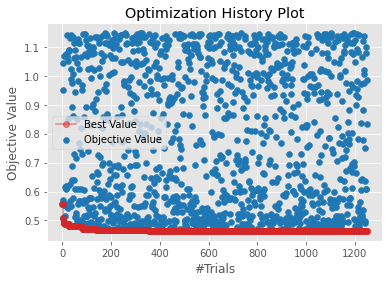

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('GB_RS_HIST.pdf')

In [ ]:
print('GB, random search, best trial:')
print(study.best_trial.params)
print('GB, random search, best RMSE:')
print(study.best_value)
print('GB, random search, best trial number:')
print(study.best_trial.number)

GB, random search, best trial:
{'n': 200, 'max_depth': 8, 'lr': 0.23882714926441595, 'l2_reg': 3.6842561482512632}
GB, random search, best RMSE:
0.4639541700551148
GB, random search, best trial number:
421


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1440x1296 with 0 Axes>

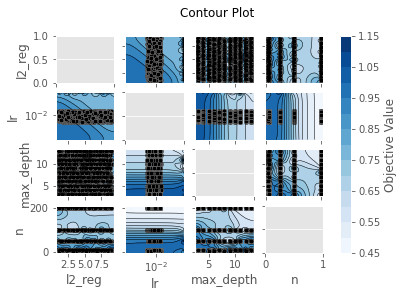

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=["n", "max_depth", "lr", "l2_reg"])
plt.savefig('GB_RS_CP.pdf')

In [ ]:
model = CatBoostRegressor(n_estimators=study.best_trial.params['n'], 
                          max_depth=study.best_trial.params['max_depth'], learning_rate=study.best_trial.params['lr'], 
                          l2_leaf_reg=study.best_trial.params['l2_reg'], eval_metric='RMSE')
print('GB, random search, RMSE on test:')
print(evaluate_RMSE(model, X_train, y_train, X_test, y_test))

GB, random search, RMSE on test:
0:	learn: 1.0052360	total: 10.3ms	remaining: 2.05s
1:	learn: 0.8852096	total: 21.1ms	remaining: 2.09s
2:	learn: 0.8017732	total: 31.1ms	remaining: 2.04s
3:	learn: 0.7429556	total: 41.4ms	remaining: 2.03s
4:	learn: 0.6963098	total: 51.3ms	remaining: 2s
5:	learn: 0.6634215	total: 61.1ms	remaining: 1.98s
6:	learn: 0.6391701	total: 70.8ms	remaining: 1.95s
7:	learn: 0.6117514	total: 80.6ms	remaining: 1.93s
8:	learn: 0.5948696	total: 90.3ms	remaining: 1.92s
9:	learn: 0.5804382	total: 99.9ms	remaining: 1.9s
10:	learn: 0.5701998	total: 110ms	remaining: 1.89s
11:	learn: 0.5630666	total: 120ms	remaining: 1.88s
12:	learn: 0.5566143	total: 130ms	remaining: 1.87s
13:	learn: 0.5451595	total: 145ms	remaining: 1.92s
14:	learn: 0.5369136	total: 154ms	remaining: 1.9s
15:	learn: 0.5320742	total: 166ms	remaining: 1.9s
16:	learn: 0.5282734	total: 180ms	remaining: 1.94s
17:	learn: 0.5244407	total: 190ms	remaining: 1.92s
18:	learn: 0.5191800	total: 199ms	remaining: 1.9s
19:	l

# NSGA-II

In [ ]:
%%time
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.NSGAIISampler())
study.optimize(objective, n_trials=1250)

CPU times: user 1h 37min 17s, sys: 2min 19s, total: 1h 39min 37s
Wall time: 54min 39s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

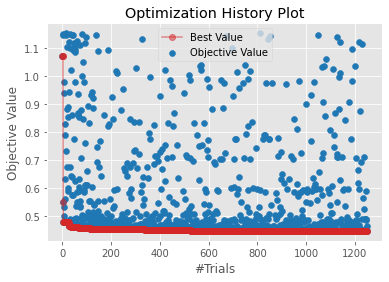

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('GB_NSGAII_HIST.pdf')

In [ ]:
print('GB, NSGA-II, best trial:')
print(study.best_trial.params)
print('GB, NSGA-II, best RMSE:')
print(study.best_value)
print('GB, NSGA-II, best trial number')
print(study.best_trial.number)

GB, NSGA-II, best trial:
{'n': 200, 'max_depth': 8, 'lr': 0.24253105555821236, 'l2_reg': 5.116765739848688}
GB, NSGA-II, best RMSE:
0.4462436246500603
GB, NSGA-II, best trial number
527


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

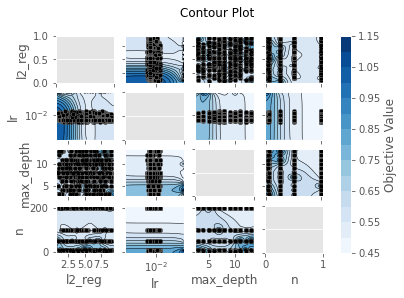

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=["n", "max_depth", "lr", "l2_reg"])
plt.savefig('GB_NSGAII_CP.pdf')

In [ ]:
model = CatBoostRegressor(n_estimators=study.best_trial.params['n'], 
                          max_depth=study.best_trial.params['max_depth'], learning_rate=study.best_trial.params['lr'], 
                          l2_leaf_reg=study.best_trial.params['l2_reg'], eval_metric='RMSE')
print('GB, NSGA-II, RMSE on test:')
print(evaluate_RMSE(model, X_train, y_train, X_test, y_test))

GB, NSGA-II, RMSE on test:
0:	learn: 1.0032670	total: 9.02ms	remaining: 1.79s
1:	learn: 0.8890350	total: 18.2ms	remaining: 1.8s
2:	learn: 0.8084189	total: 27.6ms	remaining: 1.81s
3:	learn: 0.7437144	total: 36.8ms	remaining: 1.8s
4:	learn: 0.7039810	total: 46ms	remaining: 1.79s
5:	learn: 0.6698842	total: 55.4ms	remaining: 1.79s
6:	learn: 0.6367496	total: 64.7ms	remaining: 1.78s
7:	learn: 0.6130886	total: 73.8ms	remaining: 1.77s
8:	learn: 0.5997346	total: 83.1ms	remaining: 1.76s
9:	learn: 0.5805699	total: 92.1ms	remaining: 1.75s
10:	learn: 0.5694162	total: 101ms	remaining: 1.74s
11:	learn: 0.5617907	total: 110ms	remaining: 1.73s
12:	learn: 0.5522982	total: 119ms	remaining: 1.71s
13:	learn: 0.5461046	total: 128ms	remaining: 1.7s
14:	learn: 0.5387880	total: 137ms	remaining: 1.69s
15:	learn: 0.5338506	total: 147ms	remaining: 1.69s
16:	learn: 0.5300544	total: 156ms	remaining: 1.67s
17:	learn: 0.5264019	total: 168ms	remaining: 1.7s
18:	learn: 0.5238702	total: 177ms	remaining: 1.68s
19:	learn:

# TPE

In [ ]:
%%time
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=1250)

CPU times: user 1h 43min 12s, sys: 2min 48s, total: 1h 46min 1s
Wall time: 58min 32s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1440x1296 with 0 Axes>

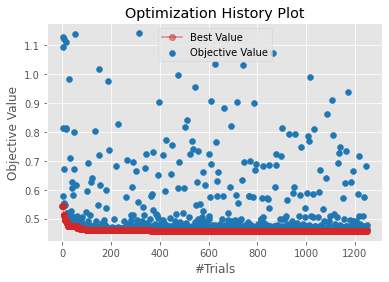

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('GB_TPE_HIST.pdf')

In [ ]:
print('GB, TPE, best trial:')
print(study.best_trial.params)
print('GB, TPE, best RMSE:')
print(study.best_value)
print('GB, TPE, best trial number')
print(study.best_trial.number)

GB, TPE, best trial:
{'n': 200, 'max_depth': 8, 'lr': 0.24180102968295722, 'l2_reg': 3.2502820535239563}
GB, TPE, best RMSE:
0.4576424224264213
GB, TPE, best trial number
570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1440x1296 with 0 Axes>

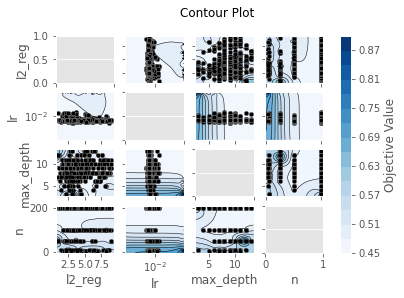

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=["n", "max_depth", "lr", "l2_reg"])
plt.savefig('GB_TPE_CP.pdf')

In [ ]:
model = CatBoostRegressor(n_estimators=study.best_trial.params['n'], 
                          max_depth=study.best_trial.params['max_depth'], learning_rate=study.best_trial.params['lr'], 
                          l2_leaf_reg=study.best_trial.params['l2_reg'], eval_metric='RMSE')
print('GB, TPE, RMSE on test:')
print(evaluate_RMSE(model, X_train, y_train, X_test, y_test))

GB, TPE, RMSE on test:
0:	learn: 1.0031522	total: 9.49ms	remaining: 1.89s
1:	learn: 0.8819712	total: 18.3ms	remaining: 1.81s
2:	learn: 0.7981422	total: 27.2ms	remaining: 1.79s
3:	learn: 0.7423181	total: 37.7ms	remaining: 1.85s
4:	learn: 0.6936549	total: 48ms	remaining: 1.87s
5:	learn: 0.6607831	total: 57ms	remaining: 1.84s
6:	learn: 0.6257474	total: 66.2ms	remaining: 1.82s
7:	learn: 0.6059384	total: 75ms	remaining: 1.8s
8:	learn: 0.5933496	total: 84ms	remaining: 1.78s
9:	learn: 0.5754891	total: 93.3ms	remaining: 1.77s
10:	learn: 0.5661657	total: 102ms	remaining: 1.76s
11:	learn: 0.5549858	total: 111ms	remaining: 1.75s
12:	learn: 0.5478016	total: 120ms	remaining: 1.73s
13:	learn: 0.5398350	total: 130ms	remaining: 1.72s
14:	learn: 0.5319097	total: 139ms	remaining: 1.72s
15:	learn: 0.5266854	total: 148ms	remaining: 1.71s
16:	learn: 0.5234818	total: 157ms	remaining: 1.69s
17:	learn: 0.5187467	total: 168ms	remaining: 1.7s
18:	learn: 0.5149004	total: 184ms	remaining: 1.75s
19:	learn: 0.51170

# CMA-ES

In [ ]:
%%time
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.CmaEsSampler())
study.optimize(objective, n_trials=1250)

CPU times: user 11min 33s, sys: 47.7 s, total: 12min 20s
Wall time: 7min 28s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1440x1296 with 0 Axes>

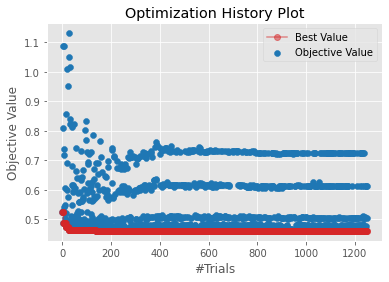

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('GB_CMAES_HIST.pdf')

In [ ]:
print('GB, CMA-ES, best trial:')
print(study.best_trial.params)
print('GB, CMA-ES, best RMSE:')
print(study.best_value)
print('GB, CMA-ES, best trial number')
print(study.best_trial.number)

GB, CMA-ES, best trial:
{'n': 200, 'max_depth': 6, 'lr': 0.27667758876145276, 'l2_reg': 4.835961814467651}
GB, CMA-ES, best RMSE:
0.4612349727962344
GB, CMA-ES, best trial number
303


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1440x1296 with 0 Axes>

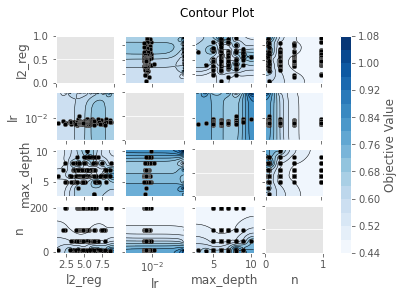

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=["n", "max_depth", "lr", "l2_reg"])
plt.savefig('GB_CMAES_CP.pdf')

In [ ]:
model = CatBoostRegressor(n_estimators=study.best_trial.params['n'], 
                          max_depth=study.best_trial.params['max_depth'], learning_rate=study.best_trial.params['lr'], 
                          l2_leaf_reg=study.best_trial.params['l2_reg'], eval_metric='RMSE')
print('GB, CMA-ES, RMSE on test:')
print(evaluate_RMSE(model, X_train, y_train, X_test, y_test))

GB, CMA-ES, RMSE on test:
0:	learn: 0.9891786	total: 4.5ms	remaining: 895ms
1:	learn: 0.8767449	total: 9.11ms	remaining: 902ms
2:	learn: 0.8050849	total: 13.7ms	remaining: 901ms
3:	learn: 0.7533368	total: 18.3ms	remaining: 898ms
4:	learn: 0.7055406	total: 22.9ms	remaining: 893ms
5:	learn: 0.6695367	total: 27.1ms	remaining: 877ms
6:	learn: 0.6486277	total: 31.4ms	remaining: 866ms
7:	learn: 0.6327342	total: 35.9ms	remaining: 861ms
8:	learn: 0.6185382	total: 40.4ms	remaining: 857ms
9:	learn: 0.6074149	total: 44.4ms	remaining: 844ms
10:	learn: 0.5932234	total: 48.9ms	remaining: 840ms
11:	learn: 0.5859471	total: 53.2ms	remaining: 834ms
12:	learn: 0.5766776	total: 57.7ms	remaining: 830ms
13:	learn: 0.5698962	total: 62.1ms	remaining: 825ms
14:	learn: 0.5643994	total: 66.4ms	remaining: 819ms
15:	learn: 0.5590552	total: 70.8ms	remaining: 814ms
16:	learn: 0.5527198	total: 75.2ms	remaining: 810ms
17:	learn: 0.5490600	total: 79.6ms	remaining: 805ms
18:	learn: 0.5446968	total: 84ms	remaining: 800ms

# Bayesian optimization

In [ ]:
! pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.2 MB/s 


In [ ]:
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_convergence, plot_gaussian_process, plot_evaluations
from skopt.space import Real, Categorical, Integer

In [ ]:
%%time
opt = BayesSearchCV(
    CatBoostRegressor(silent=True, eval_metric='RMSE'), 
    {
        'n_estimators': Categorical([5, 10, 50, 100, 200]),
        'max_depth': Integer(3, 13),
        'learning_rate': Real(1e-3, 1, 'log-uniform'),
        'l2_leaf_reg': Real(1, 9)
    },
    n_iter=300,
    cv=3,
    scoring='neg_root_mean_squared_error'
)


opt.fit(X_train, y_train)

CPU times: user 2h 20min 9s, sys: 34min 29s, total: 2h 54min 38s
Wall time: 1h 49min 42s


In [ ]:
print('GB, BO, best trial:')
print(opt.best_params_)
print('GB, BO, best RMSE:')
print(opt.best_score_)
print('GB, BO, best trial number:')
print(opt.best_index_)

GB, BO, best trial:
OrderedDict([('l2_leaf_reg', 6.070596815472617), ('learning_rate', 0.2627592440408235), ('max_depth', 8), ('n_estimators', 200)])
GB, BO, best RMSE:
-0.460485418112307
GB, BO, best trial number:
279


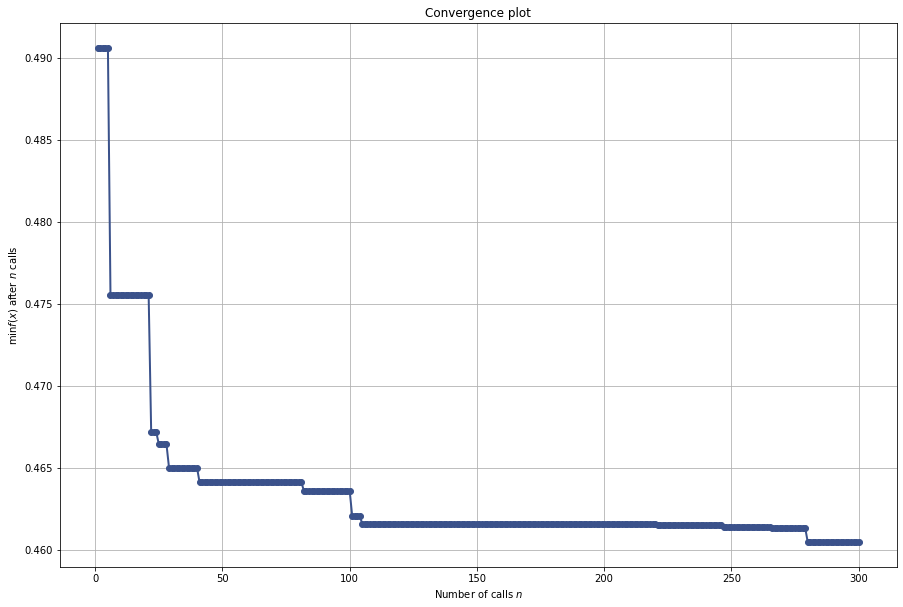

In [ ]:
plt.figure(figsize=(15, 10))
vis = plot_convergence(*opt.optimizer_results_)

<Figure size 1440x1080 with 0 Axes>

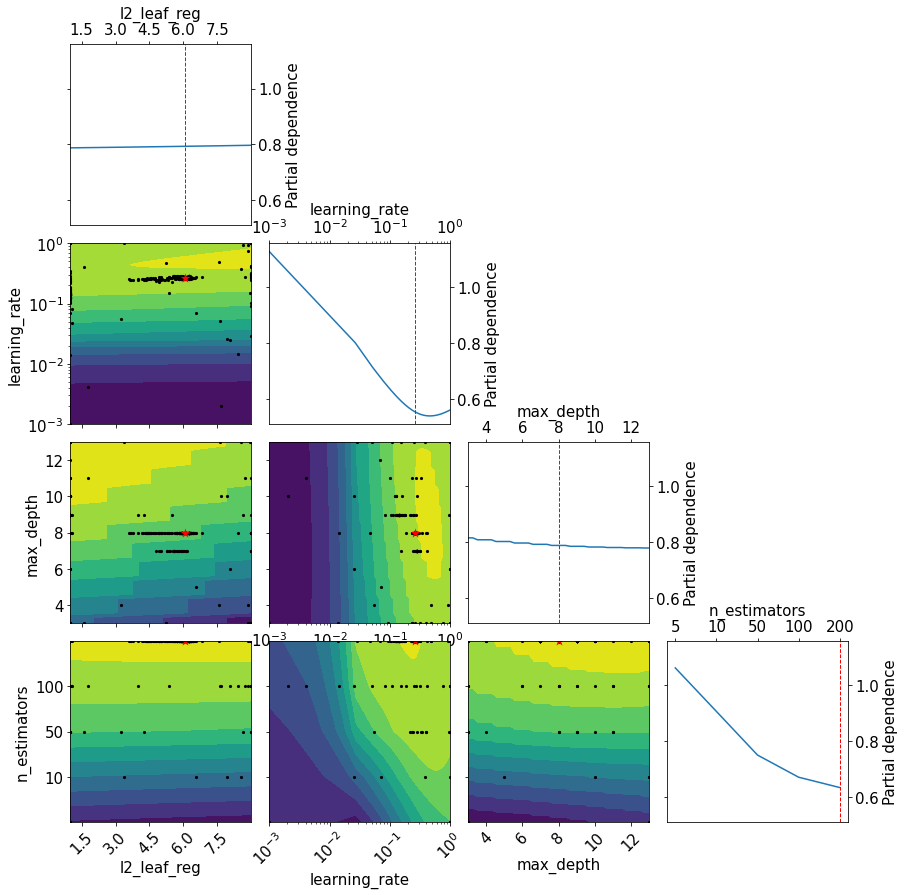

In [ ]:
plt.rc('font', size=15)
#plt.rc('lines', mew=5)
plt.figure(figsize=(20, 15))
plot_objective(*opt.optimizer_results_, size=3)
plt.savefig(fname='GS_CP_BO.pdf')

In [ ]:
model = CatBoostRegressor(n_estimators=opt.best_params_['n_estimators'], max_depth=opt.best_params_['max_depth'], 
                          learning_rate=opt.best_params_['learning_rate'], l2_leaf_reg=opt.best_params_['l2_leaf_reg'], eval_metric='RMSE')
print('GB, BO, RMSE on test:')
print(evaluate_RMSE(model, X_train, y_train, X_test, y_test))

GB, BO, RMSE on test:
0:	learn: 0.9814624	total: 9.36ms	remaining: 1.86s
1:	learn: 0.8708910	total: 18.8ms	remaining: 1.86s
2:	learn: 0.7847200	total: 28.4ms	remaining: 1.86s
3:	learn: 0.7206362	total: 37.8ms	remaining: 1.85s
4:	learn: 0.6789305	total: 47.5ms	remaining: 1.85s
5:	learn: 0.6526276	total: 57.5ms	remaining: 1.86s
6:	learn: 0.6173489	total: 67ms	remaining: 1.85s
7:	learn: 0.5982415	total: 79.3ms	remaining: 1.9s
8:	learn: 0.5859800	total: 88.3ms	remaining: 1.87s
9:	learn: 0.5695954	total: 98.1ms	remaining: 1.86s
10:	learn: 0.5592863	total: 109ms	remaining: 1.87s
11:	learn: 0.5493676	total: 118ms	remaining: 1.85s
12:	learn: 0.5429302	total: 128ms	remaining: 1.84s
13:	learn: 0.5370161	total: 138ms	remaining: 1.83s
14:	learn: 0.5308001	total: 149ms	remaining: 1.84s
15:	learn: 0.5271492	total: 159ms	remaining: 1.82s
16:	learn: 0.5238764	total: 170ms	remaining: 1.82s
17:	learn: 0.5186226	total: 182ms	remaining: 1.84s
18:	learn: 0.5141484	total: 195ms	remaining: 1.86s
19:	learn: 0